# Day 18

## part 1

- memory space is 0-70 horizontally and vertically
- coordinates are given in (X, Y) form
- start at (0, 0) and reach (70, 70)
- once a byte has fallen that tile is corrupted
- simulate the first 1024 bytes
- once that's done find the min steps to reach the exit

In [19]:
from dataclasses import dataclass
import logging

from matplotlib import pyplot as plt
from tqdm import  tqdm

from advent_of_code_utils.advent_of_code_utils import (
    parse_from_file, ParseConfig as PC, markdown, Point2 as P, plot_grid,
)

log = logging.getLogger('day 18')
logging.basicConfig(level=logging.INFO)

INFO:advent_of_code_utils.py:3450 items loaded from "day_18.txt"


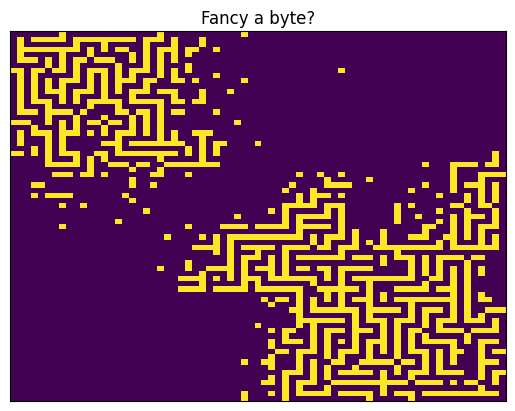

In [9]:
parser = PC('\n', PC(',', int))
coordinates = parse_from_file('day_18.txt', parser)
# lets convert to (l, c) for easy mapping to a grid
points = [P(l, c) for c, l in coordinates][:1024]
size = P(71, 71)

def plot_points(points: list[P], ax: plt.Axes) -> None:
    """plots the points passed on a 2d grid"""
    grid = [[0]*size.c for _ in range(size.l)]
    for point in points:
        grid[point.l][point.c] += 1
    
    plot_grid(grid, ax)

fig, ax = plt.subplots()
ax.set_title('Fancy a byte?')
plot_points(points, ax)

In [26]:
# there's definitely a maze afoot!
@dataclass
class Node:
    links: list[P] = None
    visited: bool = False
    score: int = None
    
    def __post_init__(self):
        if self.links is None:
            self.links = []

def get_next_node(graph: list[list[Node]]) -> Node | None:
    """returns the next node or None if no more are possible to get to"""
    min_node = None
    for line in (graph):
        for node in (line):
            # node cant be a wall, visited, or too far away
            if len(node.links) == 0:
                continue
            if node.visited:
                continue
            if node.score is None:
                continue
            if min_node is None:
                min_node = node
            elif node.score <= min_node.score:
                min_node = node
    return min_node

def get_scores(points: list[P], start: P, end: P = None) -> list[list[int]]:
    """returns a 2D grid of the distance scores"""
    log.info(f'finding distances from {start=}->{end=}')
    # create a grid of where nodes are
    grid = [[False]*size.c for _ in range(size.l)]
    for point in points:
        grid[point.l][point.c] = True
    log.info('created obstacle grid')

    graph = [[Node() for __ in range(size.c)] for _ in range(size.l)]
    for l, line in enumerate(graph):
        for c, node in enumerate(line):
            # skip walls
            if grid[l][c]:
                continue
            point = P(l, c)
            # for each adjacen point
            for adj in point.adjacent():
                # if out of bounds
                if not (0 <= adj.l < len(grid) and 0 <= adj.c < len(grid[0])):
                    continue
                # if is a wall
                if grid[adj.l][adj.c]:
                    continue
                # else must be possible to go there
                node.links.append(adj)
    log.info('created graph')

    graph[start.l][start.c].score = 0
    while True:
        # find the next node
        node = get_next_node(graph)
        # break if no node was found
        if node is None:
            log.info('visited all possible nodes without getting to end')
            break
        # update neighbours
        for point in node.links:
            link = graph[point.l][point.c]
            if link.visited:
                continue
            if link.score is None:
                link.score = node.score + 1
            elif link.score > node.score + 1:
                link.score = node.score + 1
            else:
                pass  # link is equidistant or closer than from here
        node.visited = True
    
        # if we made it to the end nows the time to check out
        if end is not None:
            if end in node.links:
                log.info('found the end!')
                break
    return graph


scores = get_scores(points, P(0, 0))

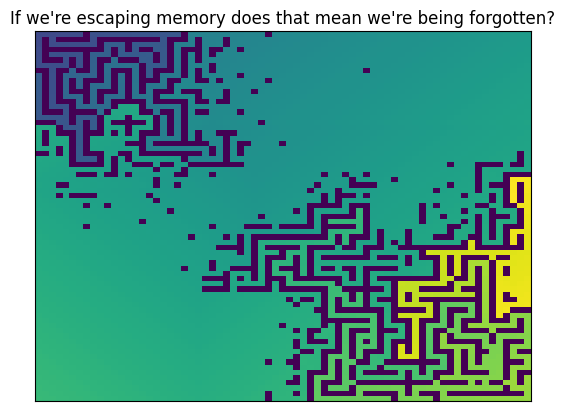

In [16]:
def plot_scores(scores: list[list[Node]], ax: plt.Axes) -> None:
    """plots the score values on a grid"""
    temp = []
    for line in scores:
        temp.append([])
        for node in line:
            # if it's a wall
            if len(node.links) == 0:
                temp[-1].append(-100)
            elif node.score is None:
                temp[-1].append(-50)
            else:
                temp[-1].append(node.score)
    plot_grid(temp, ax)

fig, ax = plt.subplots()
ax.set_title(
    'If we\'re escaping memory does that mean we\'re being forgotten?')
plot_scores(scores, ax)

In [17]:
end_distance = scores[size.l-1][size.c-1].score
markdown(f'the distance to the end is {end_distance}')

the distance to the end is 282

## part 2

- continue adding bytes after 1024th to see which one will cause the grid to be impassable
- submit the coordinates of the point as `x,y` for the solution

testing final index:  17%|█▋        | 415/2426 [00:34<02:46, 12.05it/s]


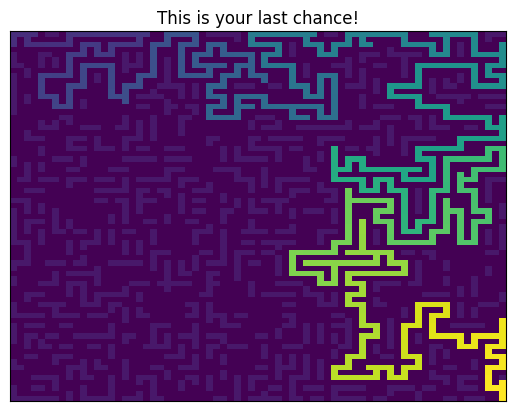

In [36]:
# since the algorithm will finish up much quicker when the path is blocked
# let's test out each set of points in reverse
points = [P(l, c) for c, l in coordinates]
def find_blocker(points: list[P], start: P, end: P) -> P:
    """returns the point that blocks the grid"""
    indecies = list(reversed(range(1024, len(points))))
    for index in tqdm(indecies, desc='testing final index'):
        scores = get_scores(points[:index], start, end)
        if scores[end.l][end.c].score is not None:
            break
    fig, ax = plt.subplots()
    ax.set_title('This is your last chance!')
    plot_scores(scores, ax)
    log.warning(f'{points[index]=} ({index=})')
    return points[index]

log.setLevel(logging.WARNING)
blocker = find_blocker(points, P(0, 0), P(70, 70))

In [35]:
markdown(f'point that seals the deal is: {blocker.c},{blocker.l}')

point that seals the deal is: 64,29